<h1>Introducción a la Simulación con SimPy</h1>
<h2>Lab 7 - Parte 1</h2>
<h2>Camilo Mercado - David Leon</h2>


<h3>Limpieza y preparacion de los datos</h3>

<h4>Descripción de los datos</h4>

* Análisis de los datos: contienen 8 columnas y 765424 filas

* Variables y tipos de datos: contiene 8 variables con 0 Nulos

Adjunto y al final del notebook se encuentra un perfilamiento más detallado de cada una de las variables

<h4> 0. Carga de librerías necesarias para implementación y carga de datos</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
import random
import ydata_profiling as pp
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from ydata_profiling import ProfileReport



import warnings
# Ignorar las advertencias para presentacion del notebook
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="The figure layout has changed to tight", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Ignoring `palette` because no `hue` variable has been assigned.*")


Cargamos el conjunto de datos provisto

In [2]:
df = pd.read_excel('SD Feb-May 2019.xlsx')

<strong><h4>1. Entendimiento de los datos</h4></strong>

Para entender los datos se considera importante entender la cantidad de datos que se tiene, verificar cuantas columnas y filas tienen los datos proporcionados

In [3]:
df_dim = df.shape
print(">> El dataframe contiene {} columnas y {} filas\n".format(df_dim[1], df_dim[0]))
print(">> El dataframe se ve de la siguiente forma: ")
df.head()

>> El dataframe contiene 8 columnas y 765424 filas

>> El dataframe se ve de la siguiente forma: 


,fecha_completa,MES,DIA,MODO_ACCESO,PORTERIA,RESULTADO_EVENTO,ROL,TIPO_ACCESO
0,2019-02-04 00:53:19,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
1,2019-02-04 00:55:43,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
2,2019-02-04 00:56:17,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
3,2019-02-04 01:16:01,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,IN
4,2019-02-04 01:29:41,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT


Extraemos la hora del día de la columna 'fecha_completa' para trabajarla mas adelante.

In [4]:
df['hora'] = df['fecha_completa'].dt.hour

Verificamos los valores faltantes 

In [5]:
print(df.isnull().sum())

fecha_completa      0
MES                 0
DIA                 0
MODO_ACCESO         0
PORTERIA            0
RESULTADO_EVENTO    0
ROL                 0
TIPO_ACCESO         0
hora                0
dtype: int64


Ya que no encontramos datos faltantes, no hace falta realizar imputación

Definimos una funcion para agrupar por tipo de acceso, pues en algunos casos se puede requerir peatonal especificamente y necesitamos tenerlos claramente distinguidos.

In [6]:
def determinar_tipo_acceso(row):
    if row['MODO_ACCESO'] == 'Peatonal':
        return 'IN' if 'IN' in row['TIPO_ACCESO'] else 'OUT'
    else:
        return 'OTHER'


Aplicamos la función a cada fila del df para crear 'TIPO_ACCESO'

In [7]:
df['TIPO_ACCESO'] = df.apply(determinar_tipo_acceso, axis=1)

Mostramos las primeras filas del DataFrame para verificar los cambios

In [8]:
print(df.head())

       fecha_completa      MES  DIA MODO_ACCESO  \
0 2019-02-04 00:53:19  Febrero    4    Peatonal   
1 2019-02-04 00:55:43  Febrero    4    Peatonal   
2 2019-02-04 00:56:17  Febrero    4    Peatonal   
3 2019-02-04 01:16:01  Febrero    4    Peatonal   
4 2019-02-04 01:29:41  Febrero    4    Peatonal   

                           PORTERIA                    RESULTADO_EVENTO  \
0  SD                                Access Grant: Access Granted Local   
1  SD                                Access Grant: Access Granted Local   
2  SD                                Access Grant: Access Granted Local   
3  SD                                Access Grant: Access Granted Local   
4  SD                                Access Grant: Access Granted Local   

                                                 ROL TIPO_ACCESO  hora  
0  VIGILANCIA                                    ...          IN     0  
1  VIGILANCIA                                    ...         OUT     0  
2  VIGILANCIA          

<h5>1.1. Procesamiento y limpieza de Datos</h5>

Convertimos 'fecha_completa' a 'FECHA_COMPLETA' para homogeneidad en la info que tratamos

In [9]:
df.rename(columns={'fecha_completa': 'FECHA_COMPLETA'}, inplace=True)

Creamos la columna 'hora' a partir de la columna 'FECHA_COMPLETA'

In [10]:
df['hora'] = df['FECHA_COMPLETA'].dt.hour

De nuevo, mostramos las primeras filas del DataFrame para verificar los cambios

In [11]:
print(df.head())

       FECHA_COMPLETA      MES  DIA MODO_ACCESO  \
0 2019-02-04 00:53:19  Febrero    4    Peatonal   
1 2019-02-04 00:55:43  Febrero    4    Peatonal   
2 2019-02-04 00:56:17  Febrero    4    Peatonal   
3 2019-02-04 01:16:01  Febrero    4    Peatonal   
4 2019-02-04 01:29:41  Febrero    4    Peatonal   

                           PORTERIA                    RESULTADO_EVENTO  \
0  SD                                Access Grant: Access Granted Local   
1  SD                                Access Grant: Access Granted Local   
2  SD                                Access Grant: Access Granted Local   
3  SD                                Access Grant: Access Granted Local   
4  SD                                Access Grant: Access Granted Local   

                                                 ROL TIPO_ACCESO  hora  
0  VIGILANCIA                                    ...          IN     0  
1  VIGILANCIA                                    ...         OUT     0  
2  VIGILANCIA          

Finalmente verificamos para los datos faltantes, la manera de imputarlos para que estén correctamente identificados

In [12]:
df_filled = df.pivot_table(index='hora', columns='TIPO_ACCESO', aggfunc='size', fill_value=0)

Ya que tenemos la información clara, procederemos a la gráfica de los datos para obtener más información sobre el contexto de los datos.


<h5>1.2. Visualización de los datos</h5>

En esta sección se graficarán datos relevantes presentes en el dataset.

En primer lugar, procedemos a convertir la columna 'fecha_completa' a tipo datetime.

In [13]:
df['FECHA_COMPLETA'] = pd.to_datetime(df['FECHA_COMPLETA'])

Extraemos la hora de la columna 'fecha_completa'

In [14]:
df['hora'] = df['FECHA_COMPLETA'].dt.hour

Agrupamos por hora y tipo de acceso y contamos el número de registros en cada grupo

In [15]:
entradas_salidas_por_hora = df.groupby(['hora', 'TIPO_ACCESO']).size().reset_index(name='count')

In [16]:
conteo_por_categoria = df['TIPO_ACCESO'].value_counts()

print(conteo_por_categoria)

TIPO_ACCESO
IN       349977
OUT      336104
OTHER     79343
Name: count, dtype: int64


Para empezar con la visualización, empezamos con los gáficos de series temporales, en los cuales mostraremos el flujo de entradas y salidas por hora del día. Este se ve a continuación:

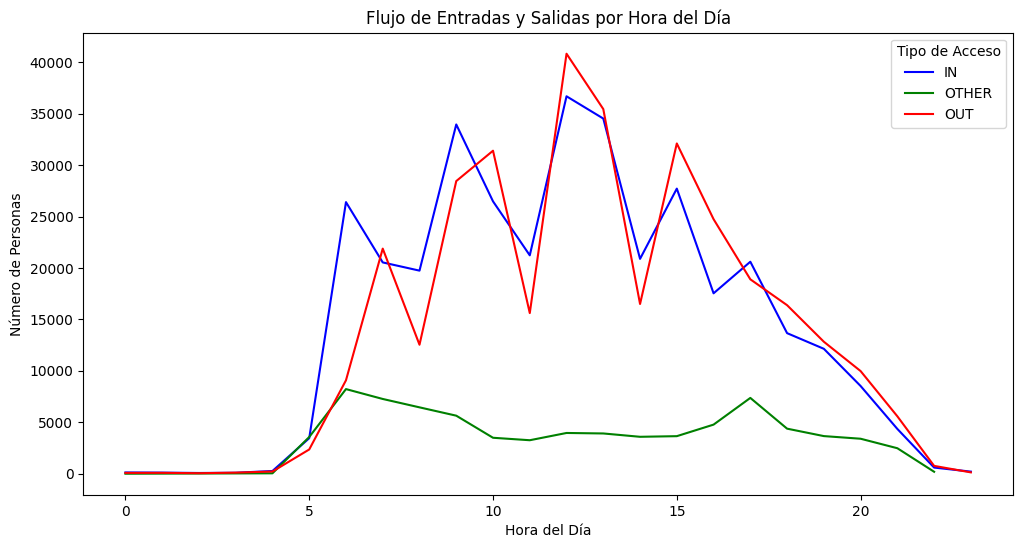

In [17]:
palette = {'IN': 'blue', 'OUT': 'red', 'OTHER': 'green'}

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=entradas_salidas_por_hora, x='hora', y='count', hue='TIPO_ACCESO', palette=palette)
plt.title('Flujo de Entradas y Salidas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Personas')
plt.legend(title='Tipo de Acceso')
plt.show()


Posteriormente, procedemos con un histograma, en el cual se puede observar con más detenimiento el número de ingresos y salidas por parte del personal peatonal y también en verde se pueden observar las entradas o salidas de otros tipos de acceso. 

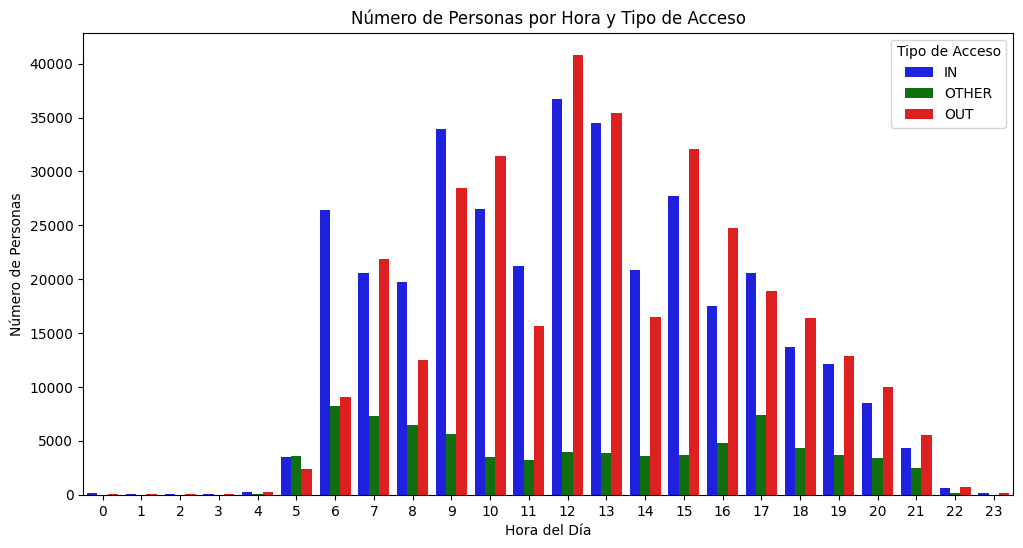

In [18]:
palette = {'IN': 'blue', 'OUT': 'red', 'OTHER': 'green'}
plt.figure(figsize=(12, 6))
sns.barplot(data=entradas_salidas_por_hora, x='hora', y='count', hue='TIPO_ACCESO', palette=palette)
plt.title('Número de Personas por Hora y Tipo de Acceso')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Personas')
plt.legend(title='Tipo de Acceso')
plt.show()

Finalmente, para este apartado, creamos un grafico de dispersion con los datos proveidos tal como se solicita. En este gráfico se pueden ver los highlights de ingresos y salidas más fácil pues los picos y valles se ven mas claros, esto relacionandolo a la hora del día nos puede dar una información importante sobre el flujo del edificio. 

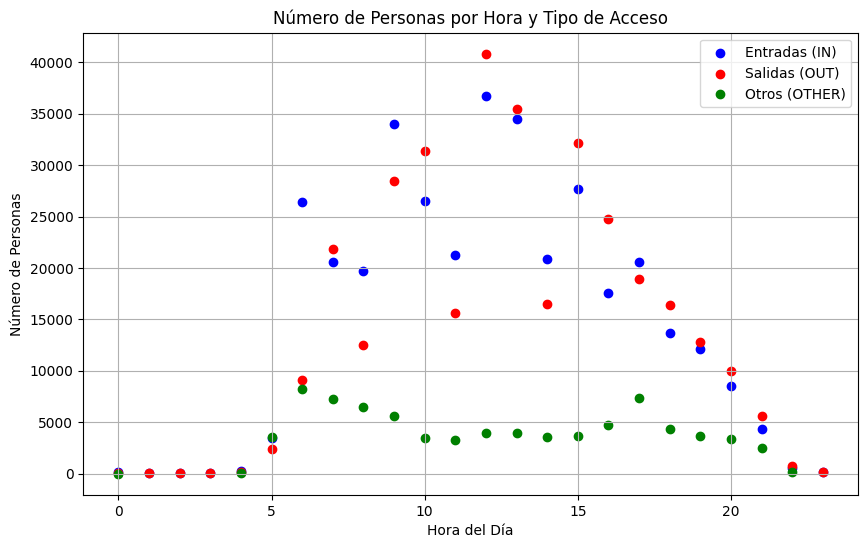

In [19]:
# Dividir el DataFrame en tres DataFrames separados por tipo de acceso
entradas = entradas_salidas_por_hora[entradas_salidas_por_hora['TIPO_ACCESO'] == 'IN']
salidas = entradas_salidas_por_hora[entradas_salidas_por_hora['TIPO_ACCESO'] == 'OUT']
otros = entradas_salidas_por_hora[entradas_salidas_por_hora['TIPO_ACCESO'] == 'OTHER']

# Graficar dispersión para entradas
plt.figure(figsize=(10, 6))
plt.scatter(entradas['hora'], entradas['count'], color='blue', label='Entradas (IN)')

# Graficar dispersión para salidas
plt.scatter(salidas['hora'], salidas['count'], color='red', label='Salidas (OUT)')

# Graficar dispersión para otros
plt.scatter(otros['hora'], otros['count'], color='green', label='Otros (OTHER)')

plt.title('Número de Personas por Hora y Tipo de Acceso')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Personas')
plt.legend()
plt.grid(True)
plt.show()


Una vez creamos los graficos solicitados, procedemos con las estadísticas clave.

<h5>1.3 Estadisticas Clave</h5>

Procedemos con la busqueda de estadisticas clave, que son: tasas promedio de entradas y salidas, desglosadas por hora, día de la semana y categoría de usuario.

Para este apartado es necesario extraer el dia de la semana como una variable con el cual vamos a realizar análisis por lo que se hace la siguiente transformacion:

In [20]:
df['dia_semana'] = df['FECHA_COMPLETA'].dt.dayofweek

Posteriormente, procedemos a agrupar por hora y tipo de acceso y contar el número de registros en cada grupo

In [21]:
entradas_salidas_por_hora = df.groupby(['hora', 'TIPO_ACCESO']).size().reset_index(name='count')

Ahora calculamos la tasa promedio de entradas y salidas por hora y la vemos

In [22]:
tasa_promedio_por_hora = entradas_salidas_por_hora.groupby('hora')['count'].mean().reset_index(name='tasa_promedio')
print("Tasa promedio de entradas y salidas por hora:")
print(tasa_promedio_por_hora)

Tasa promedio de entradas y salidas por hora:
    hora  tasa_promedio
0      0      68.666667
1      1      98.000000
2      2      61.500000
3      3     100.500000
4      4     174.333333
5      5    3127.666667
6      6   14574.000000
7      7   16566.333333
8      8   12913.333333
9      9   22684.000000
10    10   20460.666667
11    11   13369.000000
12    12   27164.000000
13    13   24632.000000
14    14   13661.000000
15    15   21160.000000
16    16   15688.000000
17    17   15628.000000
18    18   11478.666667
19    19    9546.000000
20    20    7304.000000
21    21    4138.333333
22    22     518.000000
23    23     168.000000


Seguimos con la tasa promedio de entradas y salidas por día de la semana (lunes=0, domingo=6)

In [23]:
tasa_promedio_por_dia_semana = df.groupby(['dia_semana', 'TIPO_ACCESO']).size().reset_index(name='count')
tasa_promedio_por_dia_semana = tasa_promedio_por_dia_semana.groupby('dia_semana')['count'].mean().reset_index(name='tasa_promedio')
print("\nTasa promedio de entradas y salidas por día de la semana:")
print(tasa_promedio_por_dia_semana)


Tasa promedio de entradas y salidas por día de la semana:
   dia_semana  tasa_promedio
0           0   43589.333333
1           1   51636.666667
2           2   51667.333333
3           3   53331.000000
4           4   44603.333333
5           5    9978.000000
6           6     335.666667


Finalmente, para este apartado, calculamos la tasa promedio de entradas y salidas por categoría de usuario

In [24]:
tasa_promedio_por_categoria_usuario = df.groupby(['ROL', 'TIPO_ACCESO']).size().reset_index(name='count')
tasa_promedio_por_categoria_usuario = tasa_promedio_por_categoria_usuario.groupby('ROL')['count'].mean().reset_index(name='tasa_promedio')
print("\nTasa promedio de entradas y salidas por categoría de usuario:")
print(tasa_promedio_por_categoria_usuario)



Tasa promedio de entradas y salidas por categoría de usuario:
                                                  ROL  tasa_promedio
0   ASEO                                          ...    3887.000000
1   CONSEJO                                       ...      86.666667
2   CONTRATISTA                                   ...    4728.666667
3   DEPORTES                                      ...      57.666667
4   EMPLEADO                                      ...   32276.333333
5   ESPECIAL                                      ...      11.333333
6   ESTUDIANTE                                    ...  199167.666667
7   EXALUMNO                                      ...    8027.333333
8   EXALUNMO                                      ...      28.500000
9   EXLAUMNO                                      ...       1.500000
10  FUNDACION                                     ...      25.666667
11  INVITADO                                      ...     307.666667
12  PENSIONADO                          

De estas tasas que calculamos podemos observar que:

* Se observa un pico de actividad durante las horas laborales, con una disminución marcada en las primeras horas de la mañana y un descenso gradual hacia la noche.

* Los días laborables tienen tasas de entrada y salida más altas en comparación con los fines de semana, con los martes, miércoles y jueves mostrando las tasas más altas.

* Los estudiantes representan la mayor parte del flujo de entrada y salida, seguidos por roles como empleado y contratista. Roles menos comunes como exalumnos muestran tasas más bajas.


<h5>1.4 Modelo de Ajuste de Curvas</h5>

Para el modelo de ajuste de curvas, decidimos usar una regresión lineal con el fin de obtener información sobre como cambian las variables descritas a lo largo que pasa el día, pues esta información nos parece relevante para lo que se viene más adelante en el desarrollo del laboratorio.

Creamos el modelo de regresión lineal

In [25]:
modelo = LinearRegression()

Ajustamos el modelo a los datos, teniendo en cuenta la característica (hora del día) y la variable de respuesta (número de personas)

In [26]:
X = entradas_salidas_por_hora[['hora']]
y = entradas_salidas_por_hora['count']   
modelo.fit(X, y)

LinearRegression()

Después de esto obtenemos los coeficientes de la regresión

In [27]:
coeficiente = modelo.coef_[0]
intercepto = modelo.intercept_

Procedemos a imprimirlos para formar la ecuación

In [28]:
print("Coeficiente de la regresión:", coeficiente)
print("Intercepto de la regresión:", intercepto)

Coeficiente de la regresión: 185.26251747101864
Intercepto de la regresión: 9079.400713833178


La ecuación encontrada sería entonces y=185.2625x+9079.4007

En esta ecuación:
y es la variable dependiente, en este caso, el número de personas.
x es la variable independiente, en este caso, la hora del día.
m es el coeficiente de la regresión o la pendiente
b es el intercepto de la regresión.

De esta ecuación podemos decir que, en este caso, la pendiente es aproximadamente 185.2. Este valor indica cuánto cambia el número de personas por cada unidad de cambio en la hora del día. 

Es decir, por cada hora adicional en el día, el número de personas aumenta en promedio en 185.2625.

ya que el intercepto es aproximadamente 9079.4, podemos decir que es el valor esperado de la variable dependiente cuando todas las variables independientes son iguales a cero. Sin embargo, en este problema en particular esto no tiene sentido ya que la hora del dia no puede ser cero entonces no se interpreta.

<h5>1.5 Análisis de temporadas y tendencias</h5>

Lo primero que hacemos es analizar patrones estacionales o tendencias a largo plazo en los datos. Para esto procedemos con la descomposición estacional

In [29]:
result = seasonal_decompose(entradas_salidas_por_hora['count'], model='additive', period=24)

Procedemos con la visualización de tendencias y estacionalidad

In [30]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Empezamos con el apartado de Observado, en donde se muestra la serie temporal original, es decir, los datos tal como se presentan en el conjunto de datos sin ningún tipo de transformación.

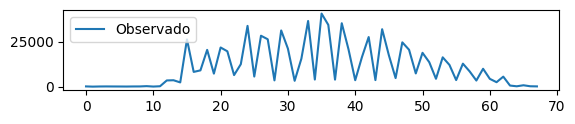

In [31]:
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')

Procedemos con Tendencia, donde se representa la dirección general en la que los datos parecen estar avanzando con el tiempo. En esta gráfica, se suavizan las fluctuaciones aleatorias para resaltar la tendencia subyacente de los datos.

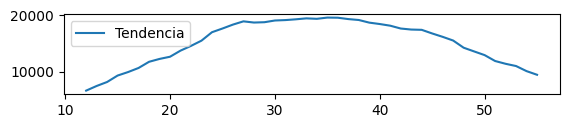

In [32]:
plt.subplot(412)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')

A continuación hablamos de estacionalidad, acá se muestran los patrones periódicos o repetitivos que ocurren en la serie temporal. Por ejemplo, esperamos ver al inicio de cada horario de clase, que hayan más ingresos y que al horario de salida se presenten más salidas. Es decir una serie de picos y valles.

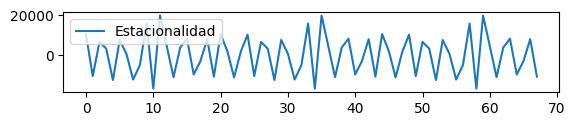

In [33]:
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

Finalmente observamos los residuos, los cuales son la variación aleatoria que no se explica por la tendencia o la estacionalidad. 

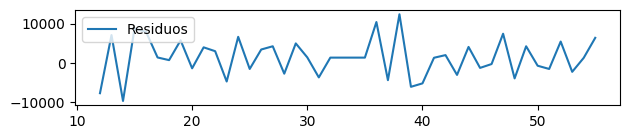

In [34]:
plt.subplot(414)
plt.plot(result.resid, label='Residuos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Finalmente, realizamos un pandas profiling para obtener mas información sobre los datos y verificar que si fueron descritos y tratados correctamente.

Nota: las fechas se separaron de la hora entonces aparece como duplicadas entonces se ven como datos repetidos, esto es esperado teniendo en cuenta las transformaciones realizadas.

In [35]:
profile = ProfileReport(df, title="Datos Entradas Edificio Santo Domingo")
profile.to_notebook_iframe()
profile.to_file("Datos Entradas Ed SD.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]